In [1]:
import requests

url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("data/car-price.csv", "wb") as file:
        file.write(response.content)
else:
    print("Failed to download the file.")

In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv('data/car-price.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
columns_to_use = ['Make','Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type',
                  'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

df = df[columns_to_use]

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

for col in df.describe(exclude='number').columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [5]:
df.fillna(0, inplace=True)

In [6]:
price_mean = df.msrp.mean()

In [7]:
df['above_average'] = df.msrp.apply(lambda x: 1 if x > price_mean else 0)

In [8]:
df = df.drop(columns='msrp')

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.shape, df_val.shape, df_test.shape

((7148, 10), (2383, 10), (2383, 10))

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.above_average
y_val = df_val.above_average
y_test = df_test.above_average

In [13]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [18]:
from sklearn.metrics import roc_auc_score

auc_result = []

for col in df_train.describe().columns:
    res = roc_auc_score(y_train, df_train[col])
    
    if res < 0.5:
        res = roc_auc_score(y_train, -df_train[col])
    auc_result.append((col, res))

df_auc_res = pd.DataFrame(auc_result, columns=['column', 'auc_score'])
highest_auc_variable = df_auc_res.sort_values('auc_score', ascending=False).iloc[0]

print("Variable with the highest AUC score:")
print(highest_auc_variable)

Variable with the highest AUC score:
column       engine_hp
auc_score     0.917103
Name: 1, dtype: object


In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [33]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = reg.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.98

In [34]:
import numpy as np 

def confusion_matrix(y_val, y_pred):
    
    result = []
    thresholds = np.linspace(0, 1, 101)
    
    for threshold in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        pred_positive = (y_pred >= threshold)
        pred_negative = (y_pred < threshold)
        
        tp = (actual_positive & pred_positive).sum() 
        tn = (actual_negative & pred_negative).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()
        
        result.append((threshold, tp, tn, fp, fn))
        
    return pd.DataFrame(result, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])

In [35]:
df_scores = confusion_matrix(y_val, y_pred)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['F1 Score'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

In [36]:
df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall,F1 Score
0,0.0,654,0,1729,0,0.274444,1.000000,0.430688
10,0.1,644,1399,330,10,0.661191,0.984709,0.791155
20,0.2,623,1526,203,31,0.754237,0.952599,0.841892
30,0.3,607,1593,136,47,0.816958,0.928135,0.869005
40,0.4,593,1626,103,61,0.852011,0.906728,0.878519
50,0.5,569,1660,69,85,0.891850,0.870031,0.880805
60,0.6,551,1679,50,103,0.916805,0.842508,0.878088
70,0.7,509,1703,26,145,0.951402,0.778287,0.856182
80,0.8,467,1714,15,187,0.968880,0.714067,0.822183
90,0.9,377,1726,3,277,0.992105,0.576453,0.729207


In [37]:
df_scores.sort_values('F1 Score', ascending=False).head()

,threshold,tp,tn,fp,fn,precision,recall,F1 Score
49,0.49,575,1659,70,79,0.891473,0.879205,0.885296
51,0.51,568,1667,62,86,0.901587,0.868502,0.884735
48,0.48,577,1655,74,77,0.886329,0.882263,0.884291
45,0.45,585,1644,85,69,0.873134,0.894495,0.883686
52,0.52,565,1668,61,89,0.902556,0.863914,0.882812


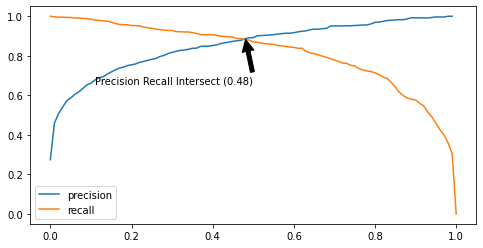

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_scores.threshold, df_scores.precision, label='precision')
ax.plot(df_scores.threshold, df_scores.recall, label='recall')

ax.annotate('Precision Recall Intersect (0.48)',
            xy=(0.48, 0.892523), xycoords='data',
            xytext=(0.5, 0.68), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.legend();

In [38]:
# Find the maximal F1 Score and its corresponding threshold
max_f1_score_row = df_scores[df_scores['F1 Score'] == df_scores['F1 Score'].max()]

# Print the maximal F1 Score and its corresponding threshold
max_f1_score = max_f1_score_row['F1 Score'].values[0]
max_f1_score_threshold = max_f1_score_row['threshold'].values[0]

print("Max F1 Score:", max_f1_score)
print("Threshold corresponding to Max F1 Score:", max_f1_score_threshold)

Max F1 Score: 0.8852963818321786
Threshold corresponding to Max F1 Score: 0.49


In [42]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [46]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

mean_auc = np.mean(scores)
std_auc = np.std(scores)

print('Mean AUC: %.3f' % mean_auc)
print('Standard Deviation of AUC across folds: %.3f' % std_auc)

Mean AUC: 0.981
Standard Deviation of AUC across folds: 0.003


In [49]:
best_mean_auc = -1  # Initialize with a low value
best_C = None
best_std_auc = None

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average
    
        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

    if (mean_auc > best_mean_auc) or (mean_auc == best_mean_auc and std_auc < best_std_auc) or (mean_auc == best_mean_auc and std_auc == best_std_auc and C < best_C):
        best_mean_auc = mean_auc
        best_C = C
        best_std_auc = std_auc

print('Best C:', best_C)
print('Best Mean AUC:', best_mean_auc)
print('Best Standard Deviation:', best_std_auc)

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.978 +- 0.002
C=  10, 0.984 +- 0.003
Best C: 0.01
Best Mean AUC: 0.9810784147039653
Best Standard Deviation: 0.0031524620868954153
